In [2]:
#All imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
import pickle

# Camera Calibration

Text(0.5,1,'Undistorted Image')

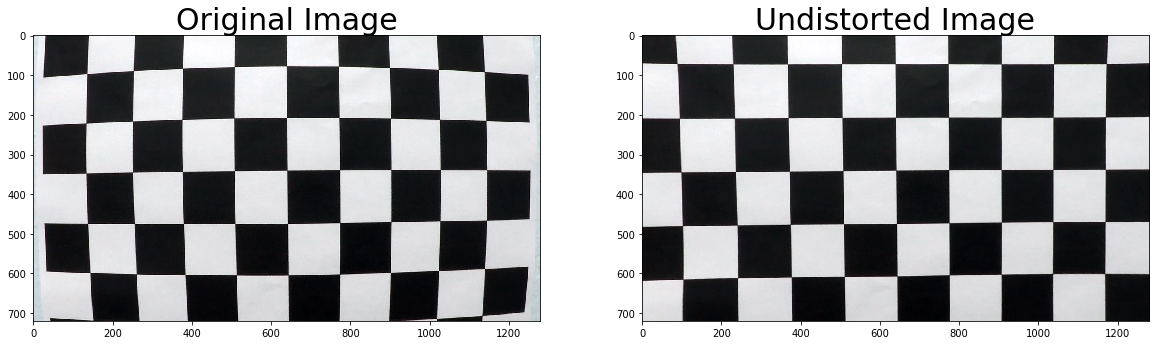

In [6]:
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

detected = 0  

# Make a list of calibration images
images = glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        detected += 1

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#We can use this undistort function to undistort image frames of video
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [50]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,None,sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,None,sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def abs_sobel_thresh_for_channel(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def plot_images(image,grad_binary):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(grad_binary, cmap='gray')
    ax2.set_title('Thresholded Gradient', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


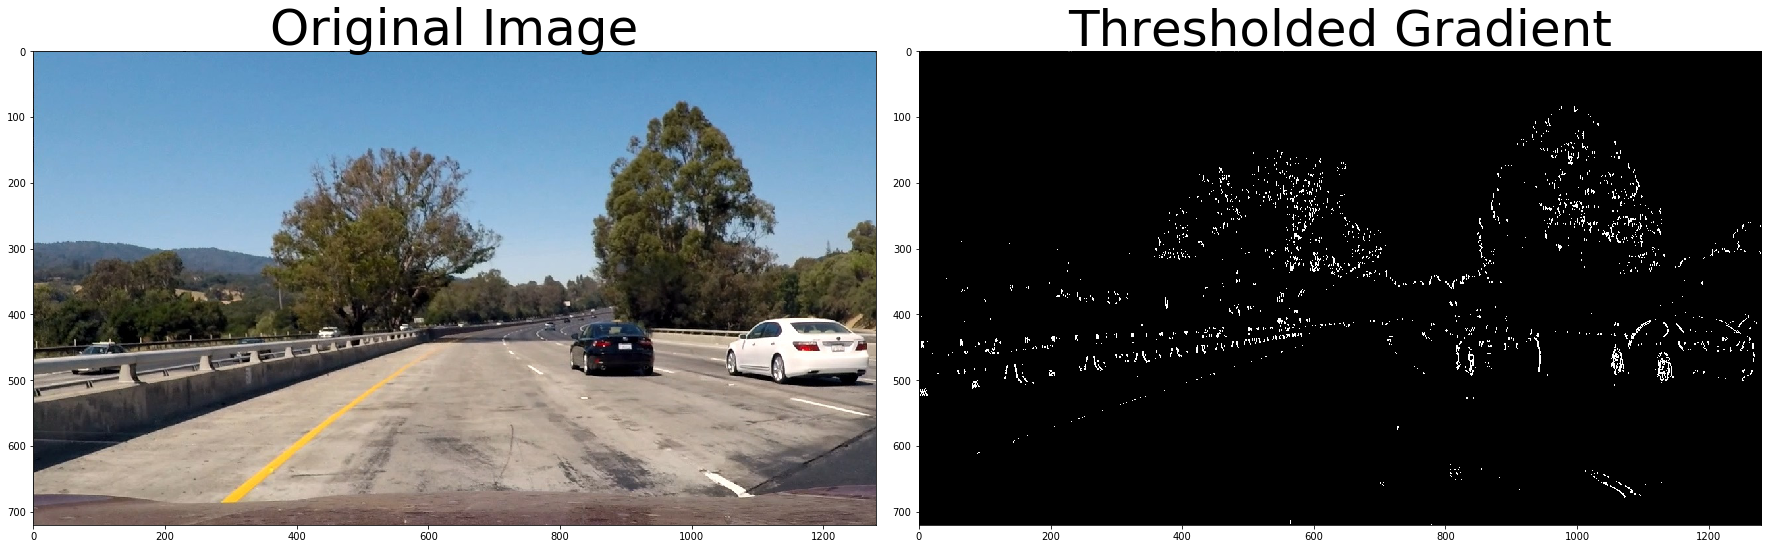

In [21]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x',sobel_kernel=3 , thresh=(50,180))
plot_images(image,grad_binary)

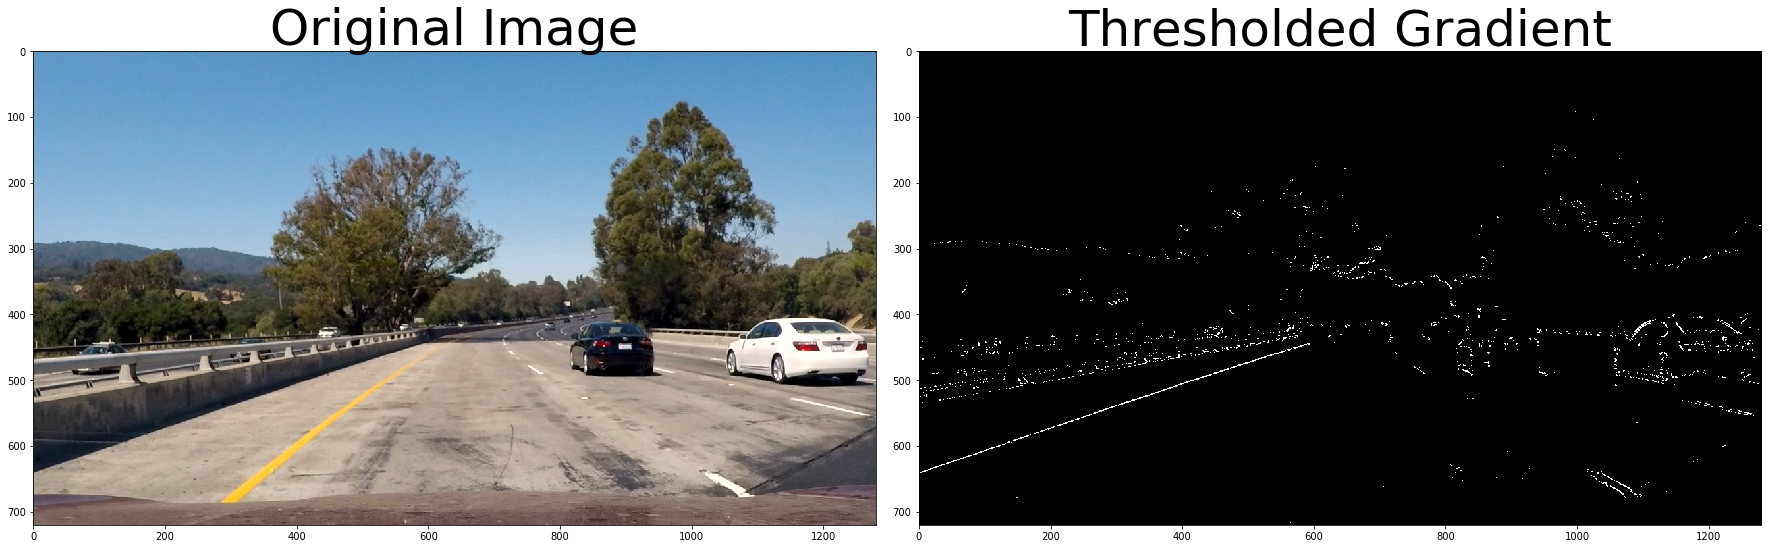

In [18]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40,180))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50,180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.4))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)  )] = 1
plot_images(image,combined)

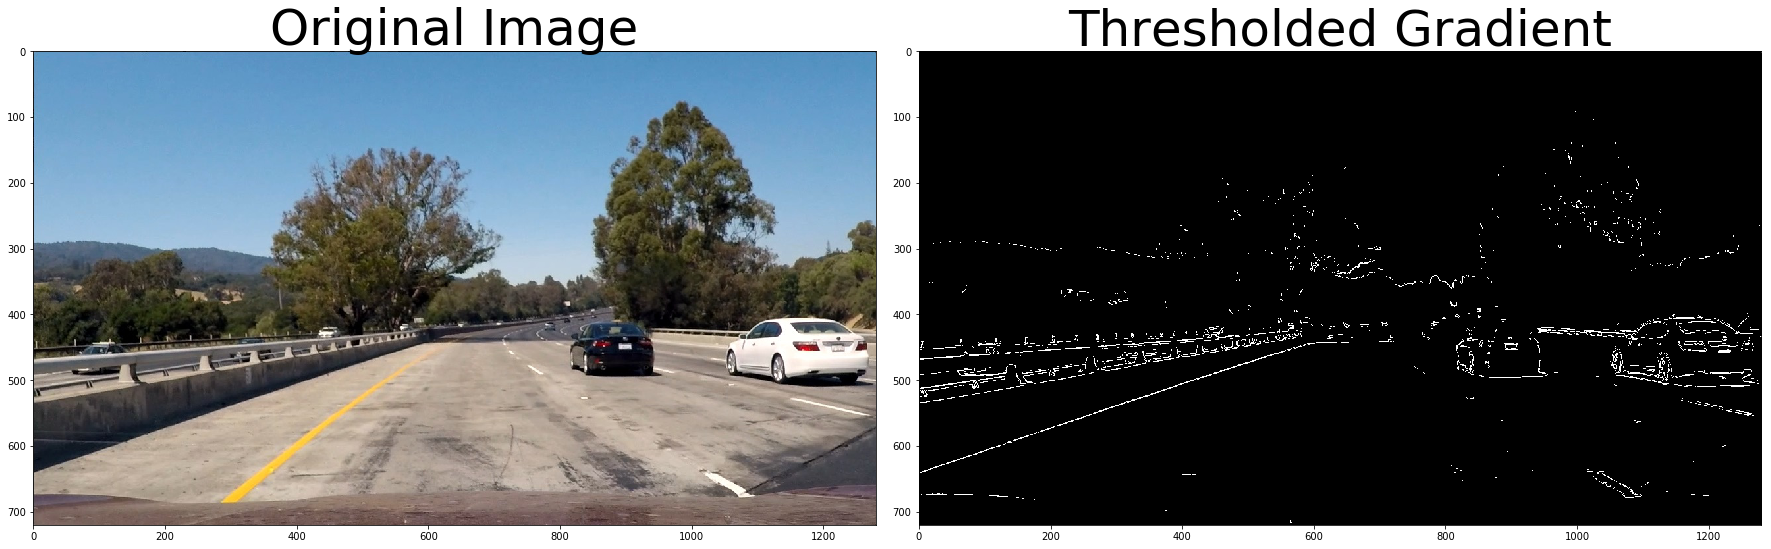

In [22]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 150))
plot_images(image,mag_binary)

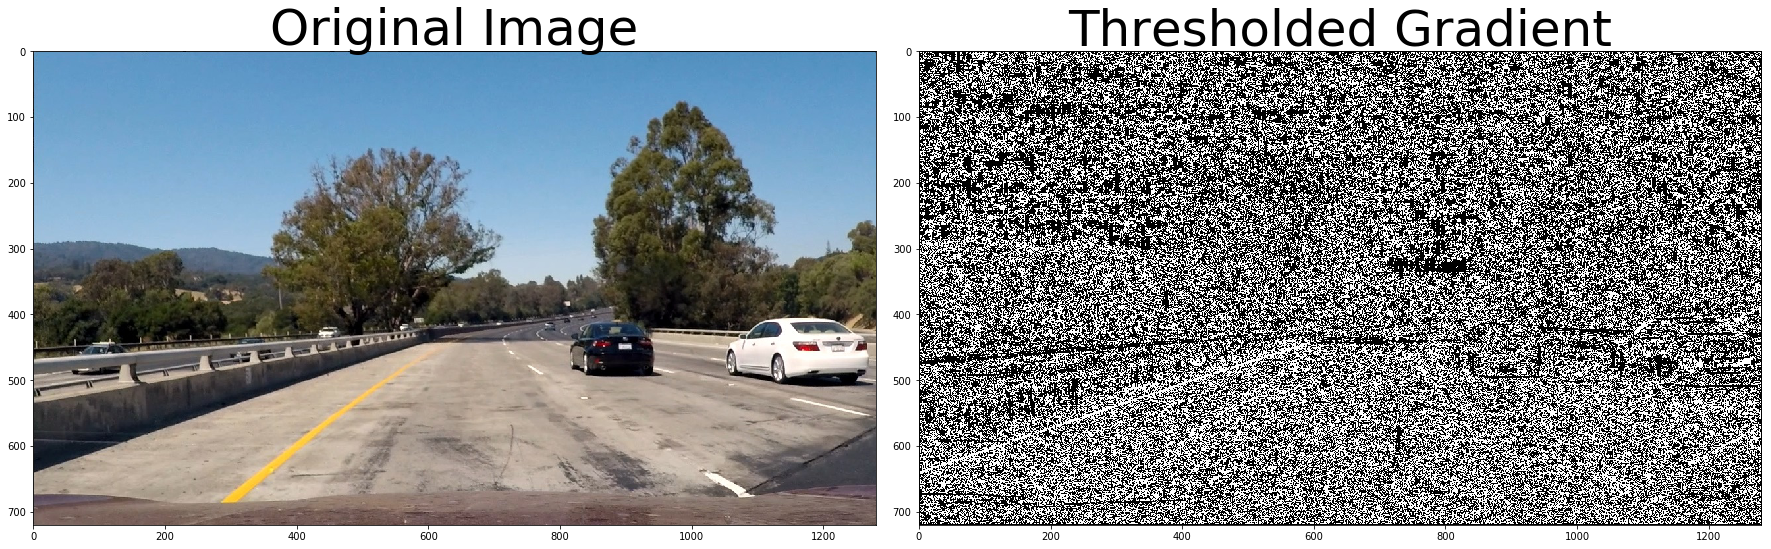

In [17]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.4))
plot_images(image,dir_binary)

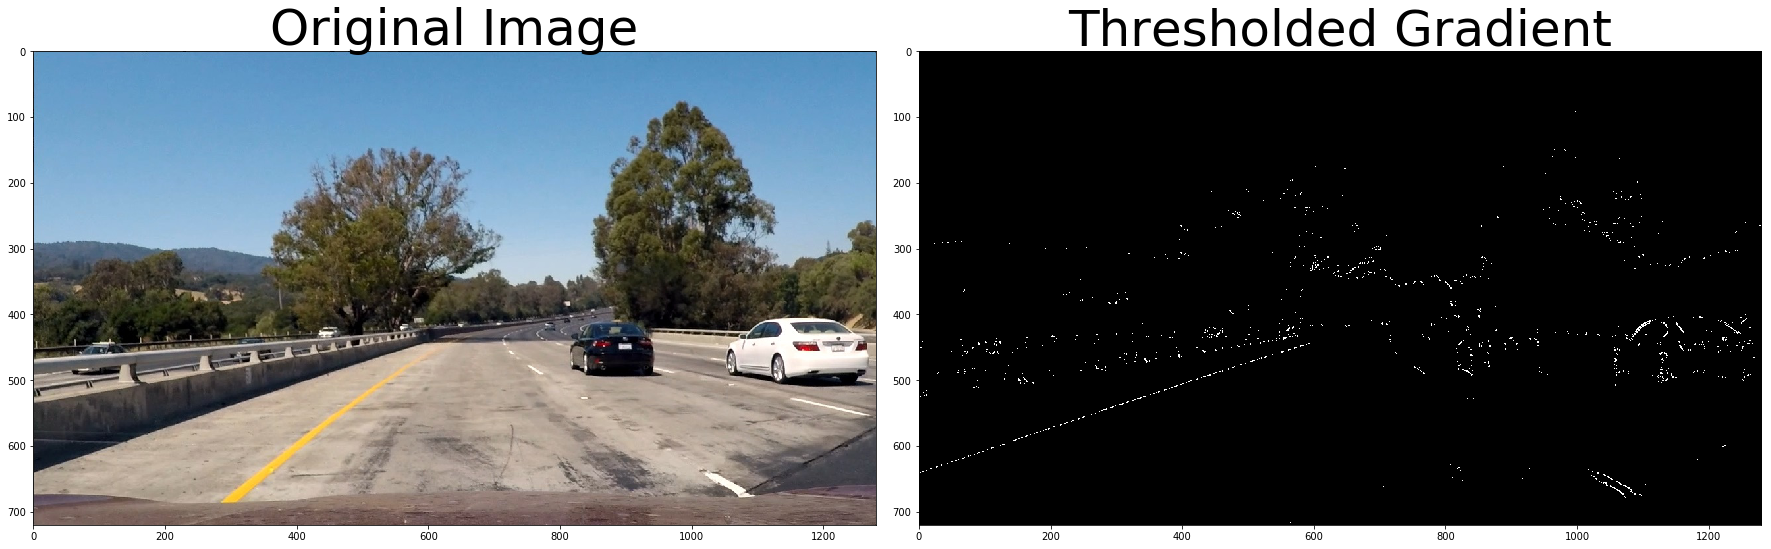

In [16]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.copy(S) # placeholder line
    binary_output[ (S>thresh[0]) & (S<=thresh[1]) ] = 1
    
    return binary_output

# Read in an image 
image = mpimg.imread('test_images/test1.jpg')
hls_binary = hls_select(image, thresh=(90, 150))

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40,180))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50,180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.4))

combined = np.zeros_like(hls_binary)
combined[(((gradx == 1) & (grady == 1)))] = 1
plot_images(image,combined)

In [ ]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.copy(S) # placeholder line
    binary_output[ (S>thresh[0]) & (S<=thresh[1]) ] = 1
    
    return binary_output

# Read in an image 
image = mpimg.imread('test_images/test3.jpg')
hls_binary = hls_select(image, thresh=(90, 150))

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40,180))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50,180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.4))

combined = np.zeros_like(hls_binary)
combined[(((gradx == 1) & (grady == 1)))] = 1
plot_images(image,combined)

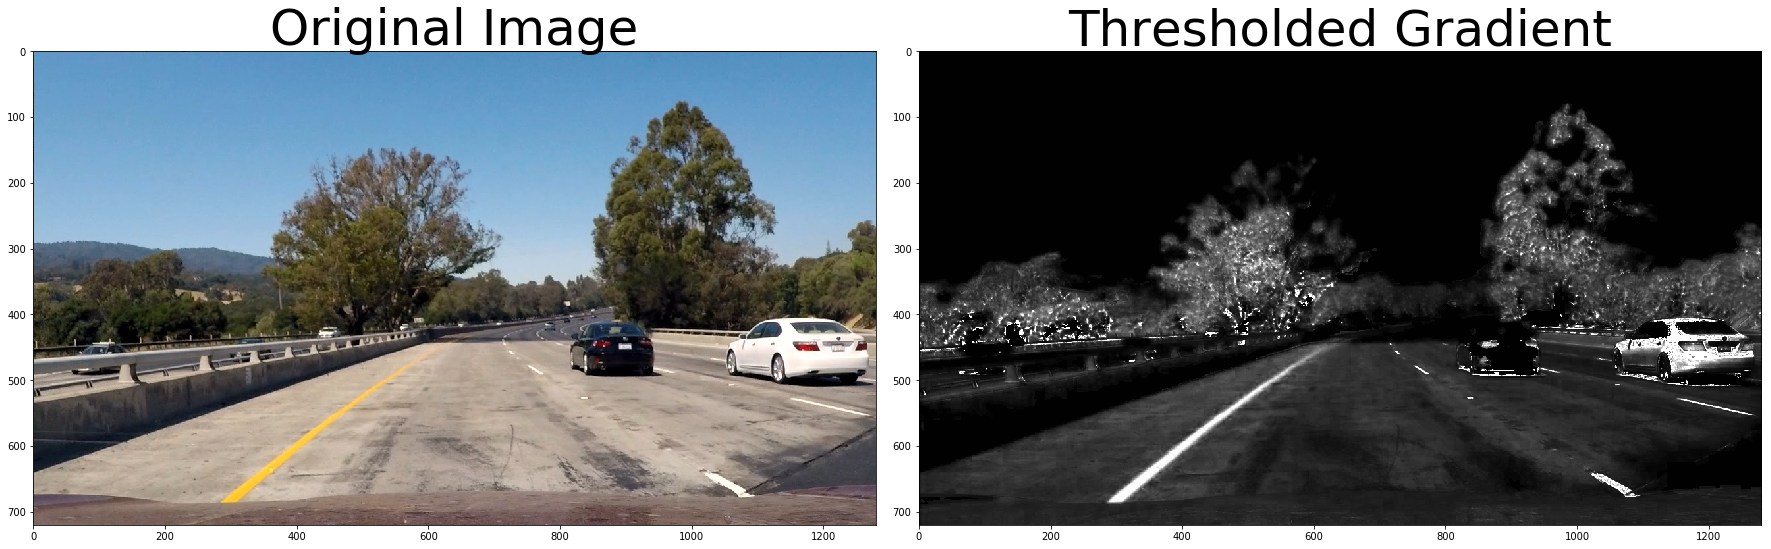

In [35]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.copy(S) # placeholder line
    binary_output[ (H>thresh[0]) & (H<=thresh[1]) ] = 1
    
    return binary_output

# Read in an image 
image = mpimg.imread('test_images/test1.jpg')
hls_binary = hls_select(image, thresh=(90, 150))
plot_images(image,hls_binary)

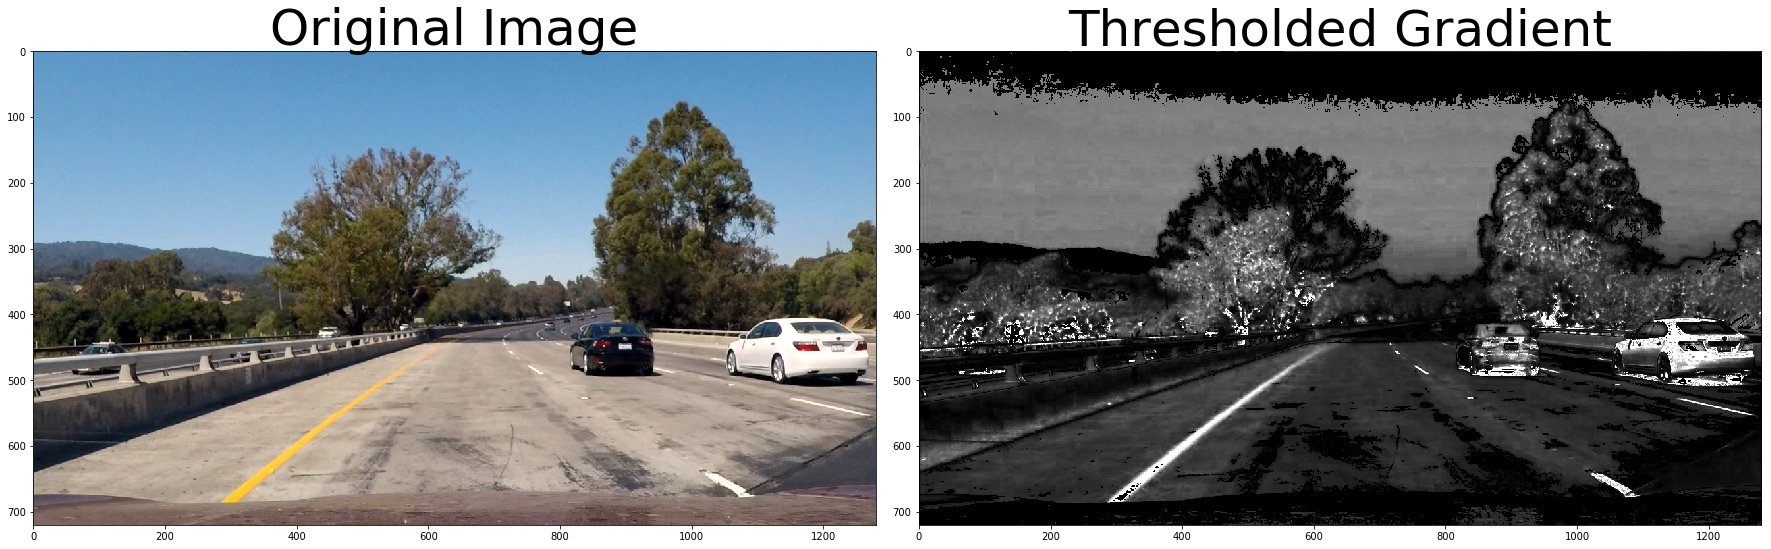

In [33]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.copy(S) # placeholder line
    binary_output[ (L>thresh[0]) & (L<=thresh[1]) ] = 1
    
    return binary_output

# Read in an image 
image = mpimg.imread('test_images/test1.jpg')
hls_binary = hls_select(image, thresh=(90,150))

plot_images(image,hls_binary)

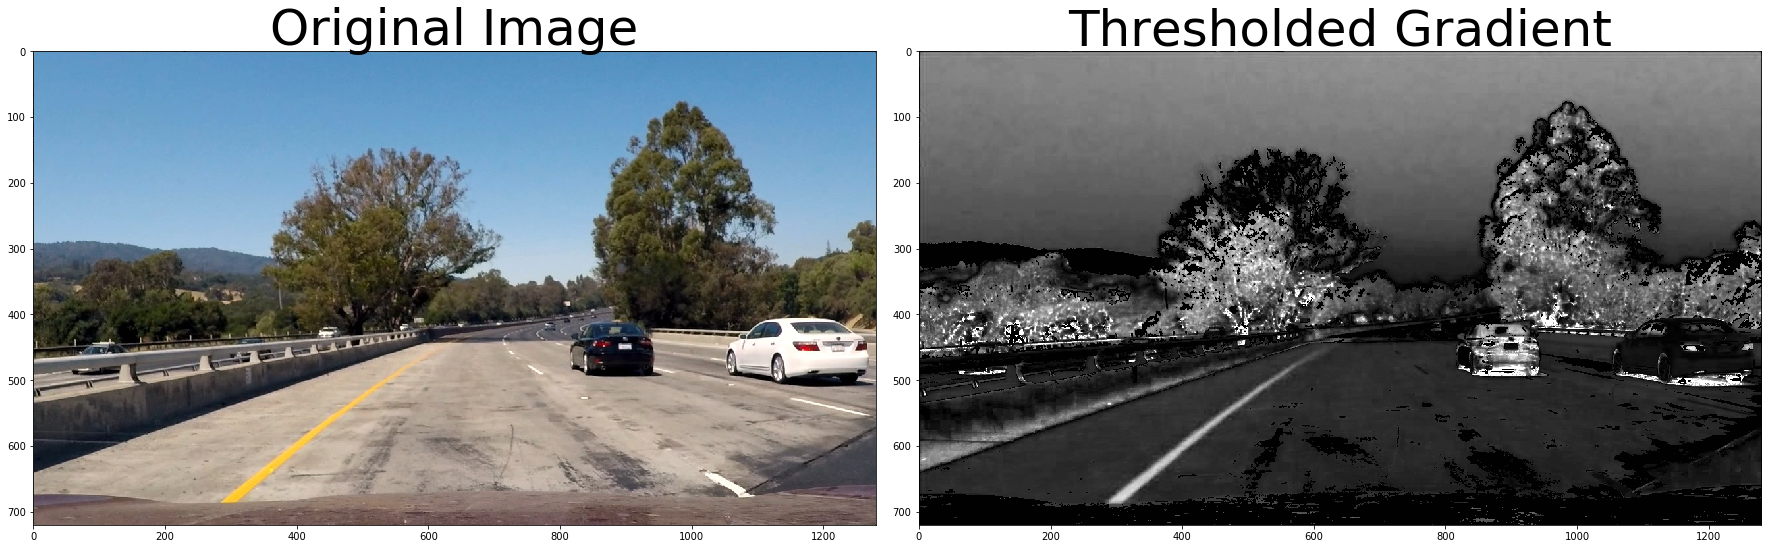

In [82]:
def hsv_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    S = hls[:,:,1]
    V = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.copy(S) # placeholder line
    binary_output[ (V>thresh[0]) & (V<=thresh[1]) ] = 1
    
    return binary_output

# Read in an image 
image = mpimg.imread('test_images/test1.jpg')
hsv_binary = hsv_select(image, thresh=(90, 150))
plot_two(image,hsv_binary)

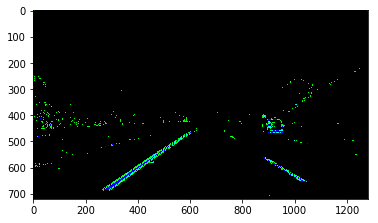

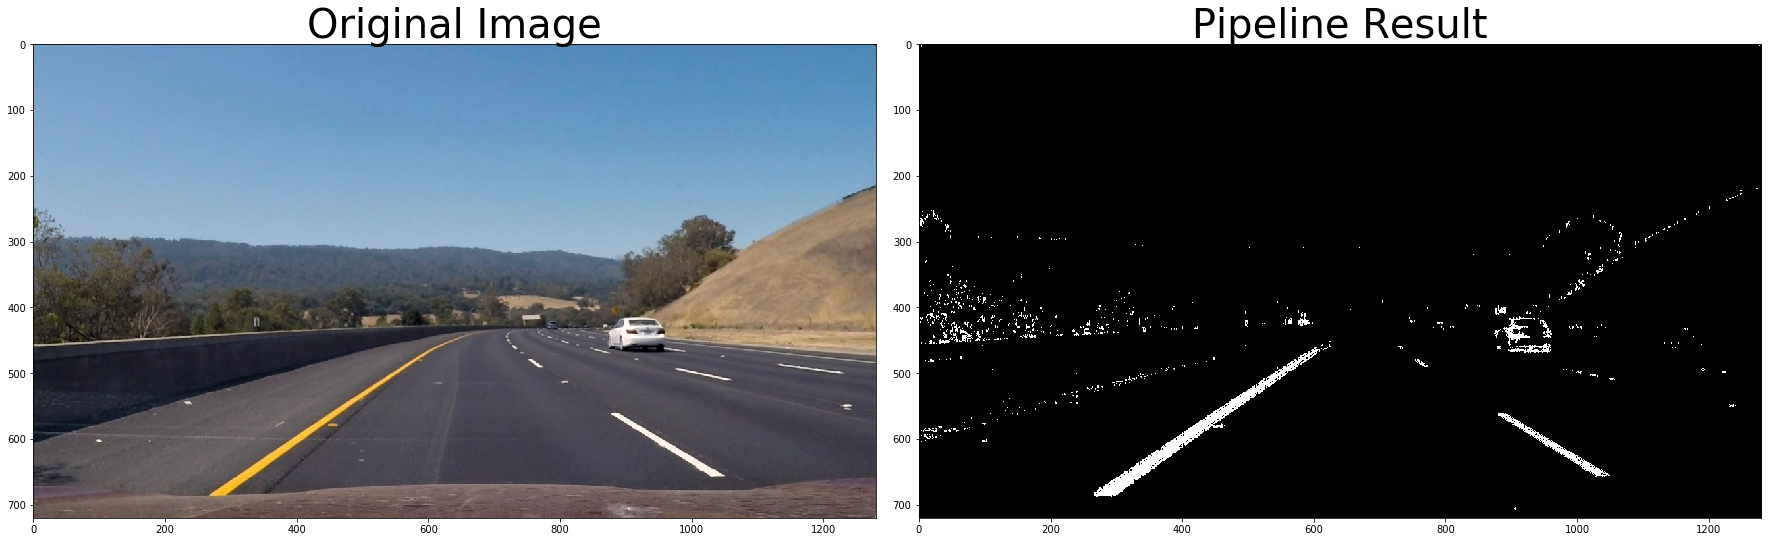

In [46]:


image = mpimg.imread('test_images/test3.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(140, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    plt.imshow(color_binary)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



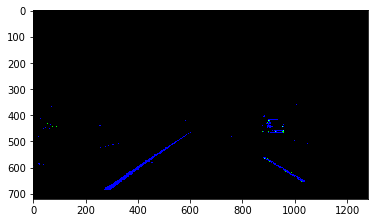

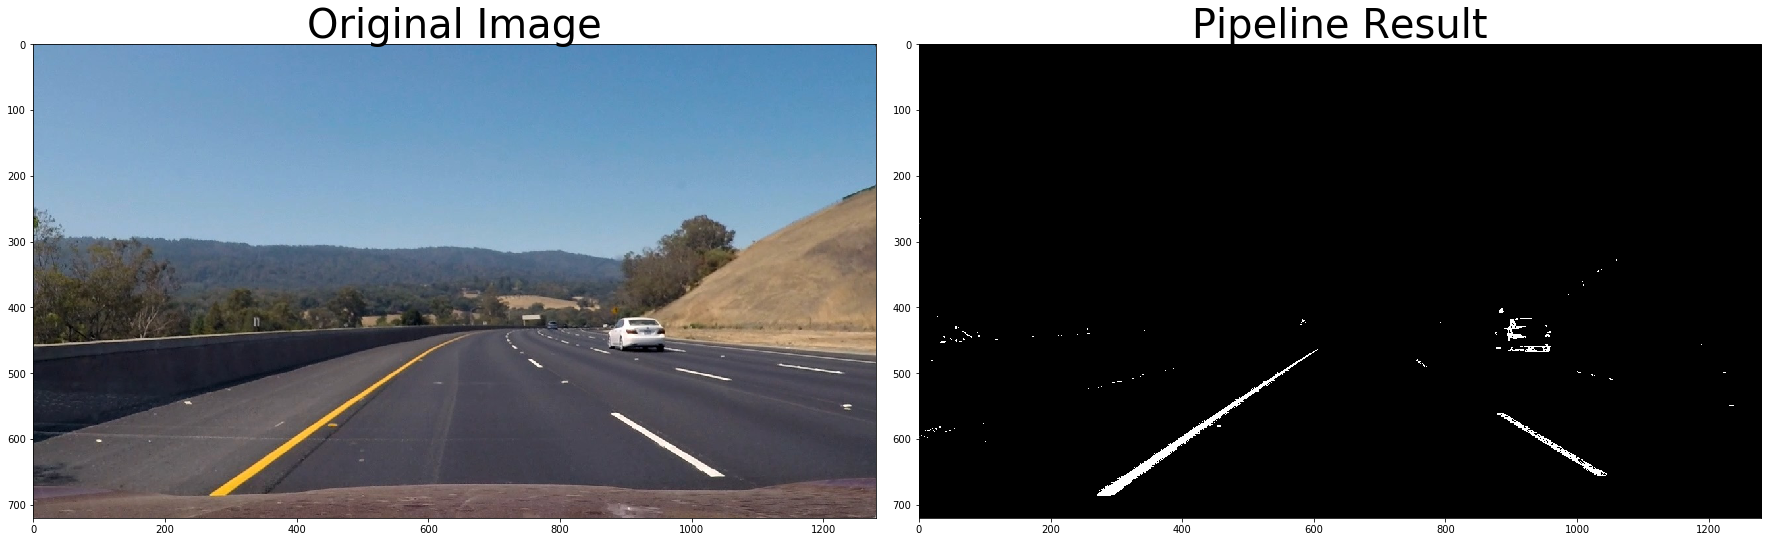

In [51]:


image = mpimg.imread('test_images/test3.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(140, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
#     sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
#     abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
#     # Threshold x gradient
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sxbinary = abs_sobel_thresh_for_channel(img=s_channel,orient='x',sobel_kernel=3,thresh=s_thresh)
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    plt.imshow(color_binary)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

